Since g2 data from measurements are saved in .spe files so we import an external library to read such files to get data in numpy arrays.

In [ ]:
# import libraries we need
%pylab inline
from implementations import sdt
import sys
sys.path.append('./sdt_reader/')
from tensorflow import keras

In [ ]:
# read data files
t1, y1 = sdt.read('./sdt_files/Antibunching_Rh110_DPC.sdt')
t2, y2 = sdt.read('./sdt_files/Antibunching_Rh110_Spc.sdt')

In [ ]:
# cut off the first and last few zero data points
y2 = y2[np.argwhere(y2>0)].flatten()
t2 = t2[np.argwhere(y2>0)].flatten()

We need to manually set the dip as the zero time delay. And also normalize the g2 signal to its maximum.

In [ ]:
# normalize g2 values and zero the time delay
t1_norm, y1_norm = sdt.normalize(t1,y1)
t2_norm, y2_norm = sdt.normalize(t2,y2)

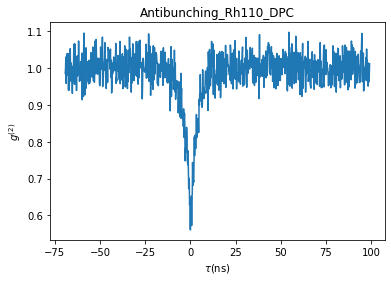

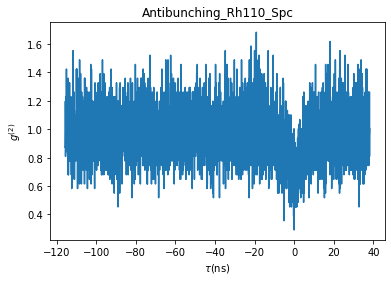

In [264]:
# take a look at the data
plt.figure(1)

plt.title('Antibunching_Rh110_DPC')
plt.xlabel(r'$\tau$(ns)')
plt.ylabel(r'$g^{(2)}$') # un-normalized
plt.plot(t1_norm,y1_norm)

plt.figure(2)

plt.title('Antibunching_Rh110_Spc')
plt.xlabel(r'$\tau$(ns)')
plt.ylabel(r'$g^{(2)}$')
plt.plot(t2_norm,y2_norm)
plt.show()


# MachineLearning Part

To avoid tensorflow occupying all CPUs or GPU in a computer we need to set processing units which tensorflow has access to use.

In [284]:
# this is to limit the GPU and CPUs being occupied by tensorflow
from implementations import tf_setCPU

In [309]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)][0]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

In [574]:
# create training sequences
time_step = 2
train1 = sdt.create_train(y1_norm,time_step)
#train2x, train2y = sdt.create_train(y1,time_step
train1 = train1.reshape(train1.shape[0],train1.shape[1],1)
train2 = sdt.create_train(y2_norm,time_step)
train2 = train2.reshape(train2.shape[0],train2.shape[1],1)

In [575]:
tr1x, tr1y = create_dataset(y1_norm)
tr1x = tr1x.reshape(tr1x.shape[0],1,1)
tr2x, tr2y = create_dataset(y2_norm)
tr2x = tr2x.reshape(tr2x.shape[0],1,1)

Here I create a [1D CNN](https://keras.io/api/layers/convolution_layers/convolution1d/).

In [576]:
# create a training model
kernelsize = 7
model = keras.Sequential()
model.add(keras.layers.Input(shape=(train1.shape[1],train1.shape[2])))
model.add(keras.layers.Conv1D(filters=32, kernel_size=kernelsize, padding="same", strides=1, activation="relu")) #,input_shape=(train1.shape[0],train1.shape[1],1)
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Conv1D(filters=16, kernel_size=kernelsize, padding="same", strides=1, activation="relu")) #,input_shape=(train1.shape[0],train1.shape[1],1)
model.add(keras.layers.Conv1DTranspose(filters=16, kernel_size=kernelsize,activation="relu", padding="same"))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Conv1DTranspose(filters=32, kernel_size=kernelsize,activation="relu", padding="same"))
model.add(keras.layers.Conv1DTranspose(filters=1, kernel_size=kernelsize, padding="same"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_104 (Conv1D)          (None, 2, 32)             256       
_________________________________________________________________
dropout_98 (Dropout)         (None, 2, 32)             0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 2, 16)             3600      
_________________________________________________________________
conv1d_transpose_143 (Conv1D (None, 2, 16)             1808      
_________________________________________________________________
dropout_99 (Dropout)         (None, 2, 16)             0         
_________________________________________________________________
conv1d_transpose_144 (Conv1D (None, 2, 32)             3616      
_________________________________________________________________
conv1d_transpose_145 (Conv1D (None, 2, 1)            

In [584]:
history = model.fit(train2,train2,epochs=20,validation_split=.1)

Epoch 1/20
105/105 [==============================] - 0s 930us/step - loss: 0.0218 - val_loss: 0.0241
Epoch 2/20
105/105 [==============================] - 0s 754us/step - loss: 0.0103 - val_loss: 0.0035
Epoch 3/20
105/105 [==============================] - 0s 704us/step - loss: 0.0050 - val_loss: 0.0030
Epoch 4/20
105/105 [==============================] - 0s 694us/step - loss: 0.0041 - val_loss: 0.0033
Epoch 5/20
105/105 [==============================] - 0s 697us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 6/20
105/105 [==============================] - 0s 706us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/20
105/105 [==============================] - 0s 696us/step - loss: 0.0029 - val_loss: 0.0062
Epoch 8/20
105/105 [==============================] - 0s 697us/step - loss: 0.0026 - val_loss: 0.0067
Epoch 9/20
105/105 [==============================] - 0s 693us/step - loss: 0.0023 - val_loss: 0.0042
Epoch 10/20
105/105 [==============================] - 0s 715us/step - loss: 0.002

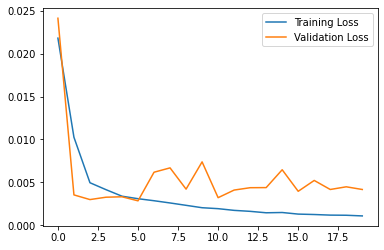

In [585]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [586]:
train2.shape

(3726, 2, 1)

In [621]:
# Get train MAE loss.
pred = model.predict(train2)


In [622]:
pred.shape

(3726, 2, 1)

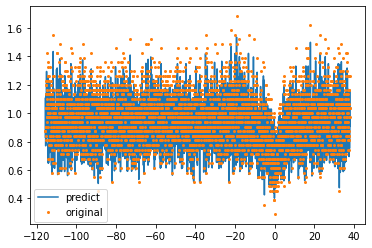

In [629]:
#for i in range(pred.shape[-1]):
plt.plot(t1_norm[:-2],pred[:,1,0],label='predict')
#plt.plot(t[anomalous_data_indices],y_norm[anomalous_data_indices],'r',label='anomaly')
plt.plot(t1_norm[:-2],train2[:,0],'.',markersize=4,label='original')
plt.legend(loc=(0.01,0.01))
plt.savefig('./../g2-coral/pred2')

# Previous

In [ ]:
# create a training model
model = keras.Sequential()
model.add(keras.layers.Input(shape=(train1.shape[1],train1.shape[2]),name='a'))
model.add(keras.layers.Conv1D(filters=32, kernel_size=50,input_shape=(train1.shape[0],train1.shape[1],1), padding="same", strides=1, activation="relu",name='b'))
model.add(keras.layers.Dropout(rate=0.2,name='c'))
model.add(keras.layers.Conv1DTranspose(filters=16, kernel_size=50, padding="same",name='d'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()